# Machine Learning (Titanic)

After exploring the Titanic dataset in the previous project, valuable insights were gained to guide the next step: building an optimal machine learning model to predict passenger survival. In this stage, two models will be developed and their performance compared - Logistic Regression and Random Forest.


#### Content:
- Libraries & Dataset
- Preprocessing
- Data Modelling
- Comparing Models
- Interpretations
- Conclusion
- Data Export Process

## Libraries & Dataset

In [642]:
# Import libraries

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [643]:
# Read dataset

df = pd.read_csv("titanic_cleaned_age_imp.csv")
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilyMembers
0,0,3,male,22.0,1,0,7.2500,S,2
1,1,1,female,38.0,1,0,71.2833,C,2
2,1,3,female,26.0,0,0,7.9250,S,1
3,1,1,female,35.0,1,0,53.1000,S,2
4,0,3,male,35.0,0,0,8.0500,S,1


## Preprocessing

Logistic Regression and Random Forest models cannot directly process raw categorical data, so categorical features will be encoded during the preprocessing stage.

### Removing Columns

In [644]:
# Checking for missing data

df.isnull().sum()

Survived         0
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilyMembers    0
dtype: int64

In [645]:
# Removing SibSp & Parch

df.drop(['SibSp', 'Parch'], axis=1, inplace=True)


# Show updated columns

df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked',
       'FamilyMembers'],
      dtype='object')

As noted in the EDA project, the SibSp and Parch columns are removed to avoid redundancy and multicollinearity, since the FamilyMembers feature is derived by combining these two columns and adding one.

### Encoding Data

In [646]:
# Data types

df.dtypes

Survived           int64
Pclass             int64
Sex               object
Age              float64
Fare             float64
Embarked          object
FamilyMembers      int64
dtype: object

In [647]:
# Encode 'Sex' as binary

df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})


# One-hot encode 'Embarked' (nominal)

embarked_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked', drop_first=True)


# Drop original 'Embarked' column and add dummy columns

df = pd.concat([df.drop('Embarked', axis=1), embarked_dummies], axis=1)

Data Encoding:
+ Sex: Converted from categorical to binary numerical format, with male = 0 and female = 1.
+ Embarked: One-hot encoding applied to create dummy variables for each category. Two new columns, Embarked_Q and Embarked_S, are generated, while Embarked_C is intentionally dropped to prevent multicollinearity. A row with both Embarked_Q and Embarked_S as False implies the passenger embarked at C.
+ Pclass: Kept in its original form, as it is an ordinal variable representing passenger class (1st, 2nd, 3rd). However, if modelling results indicate non-linear or complex interactions, one-hot encoding may be applied later to better capture these relationships.

In [648]:
# Change data types to integers

df = df.astype(int)
df.dtypes

Survived         int64
Pclass           int64
Sex              int64
Age              int64
Fare             int64
FamilyMembers    int64
Embarked_Q       int64
Embarked_S       int64
dtype: object

All values have been converted to integers, meaning any boolean value that was previously True is now 1, and any False is now 0.

In [649]:
# Updated dataframe

df.head()

,Survived,Pclass,Sex,Age,Fare,FamilyMembers,Embarked_Q,Embarked_S
0,0,3,0,22,7,2,0,1
1,1,1,1,38,71,2,0,0
2,1,3,1,26,7,1,0,1
3,1,1,1,35,53,2,0,1
4,0,3,0,35,8,1,0,1


## Data Modelling

### Define Features & Targets

In [650]:
# Defining X & y

X = df.drop('Survived', axis=1)
y = df['Survived']

In this step, the dataset is separated into input features and the target variable. The input features, denoted as X, include all columns except the 'Survived' column. The target variable, denoted as y, is the 'Survived' column, which indicates whether a passenger survived (1) or not (0).

This separation is essential for training machine learning models, where X provides the data used to make predictions, and y represents the outcome to be predicted.

### Train-Test Split

In [651]:
# Splitting the dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The dataset is split into two parts: one for training the model and one for testing it.
+ X_train and y_train are used to train the model.
+ X_test and y_test are used to evaluate the model's performance on new, unseen data.

Eighty percent of the data is allocated for training, and twenty percent for testing. The parameter random_state=42 is used to ensure that the split remains consistent across multiple runs, supporting reproducibility.

### Feature-Scaling

In [652]:
# Scaling the data

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Before training the Logistic Regression model, the input features are scaled using StandardScaler. This standardisation transforms the data so that each feature has a mean of 0 and a standard deviation of 1.

Scaling is applied only to the training and test data used for Logistic Regression, as this model is sensitive to the scale of input features. In contrast, scaling is not required for models such as Random Forests, which are unaffected by the magnitude of features.

### Train Logistic Regression

In [653]:
# Initialise model

lr = LogisticRegression(max_iter=1000)


# Fit model to training data

lr.fit(X_train_scaled, y_train)


# Predicting the test data

y_pred_lr = lr.predict(X_test_scaled)


# Accuracy score

acc_lr = accuracy_score(y_test, y_pred_lr)

A Logistic Regression model is used to predict whether a passenger survived or not.
+ The model is initialised with max_iter=1000, allowing the algorithm to run for more iterations if necessary to reach on an optimal solution.
+ The model is then trained using the scaled training data (X_train_scaled and y_train).
+ After training, predictions are made on the test data using X_test_scaled.

The model's performance is evaluated using accuracy, which indicates the percentage of correct predictions.

### Train Random Forest

In [654]:
# Random forest model object

rf = RandomForestClassifier(n_estimators=100, random_state=42)


# Fit model to training data

rf.fit(X_train, y_train)


# Predicting the test data

y_pred_rf = rf.predict(X_test)


# Accuracy score

acc_rf = accuracy_score(y_test, y_pred_rf)

A Random Forest Classifier is used to predict passenger survival. This model is initialised with 100 estimators (n_estimators=100) and a random state of 42 to ensure consistent results across runs.

The model is then fitted to the training data using X_train and y_train. After training, predictions are generated on the test dataset using X_test, and the results are stored in y_pred_rf.

To evaluate the model’s performance, accuracy is calculated by comparing the predicted values (y_pred_rf) with the actual target values (y_test). The resulting accuracy score (acc_rf) represents the proportion of correct predictions made by the model.

### Model Comparison

In [655]:
# Accuracy score comparison

print("Accuracy Score")
print(f"Logistic Regression: {acc_lr:.4f}")
print(f"Random Forest:       {acc_rf:.4f}")

Accuracy Score
Logistic Regression: 0.8045
Random Forest:       0.8268


Both Logistic Regression and Random Forest models can be evaluated using the accuracy score.
+ The Logistic Regression model achieved an accuracy of 0.8045, meaning it correctly classified approximately 80.45% of the test samples.
+ The Random Forest model outperformed Logistic Regression, with an accuracy of 0.8268, correctly predicting 82.68% of the test cases.

This comparison demonstrates that the Random Forest model delivers better predictive performance on this dataset, likely because it can capture complex relationships and feature interactions by forming nonlinear and more flexible decision boundaries.

## Comparing Models

#### Classification Report

In [656]:
# Logistic Regression

print("Logistic Regression - Classification Report")
print(classification_report(y_test, y_pred_lr))


# Random Forest

print("Random Forest - Classification Report")
print(classification_report(y_test, y_pred_rf))

Logistic Regression - Classification Report
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       105
           1       0.78      0.73      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179

Random Forest - Classification Report
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       105
           1       0.78      0.81      0.79        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



Dataset:
+ Test set with 179 samples (Class 0: 105 samples, Class 1: 74 samples).

Overall Accuracy:
+ Logistic Regression achieved an accuracy of 80% on the test set.
+ Random Forest performed better with an accuracy of 83%.

Interpretation:
+ Both models demonstrate strong predictive ability, with solid precision and recall scores for both classes.
+ The Random Forest model shows a clear advantage overall, with higher accuracy and better balance between precision and recall, especially for Class 1.
+ Logistic Regression shows slightly better recall for Class 0, but Random Forest’s improved recall for Class 1 makes it more reliable for detecting positive cases.

Conclusion:
+ The Random Forest classifier outperforms Logistic Regression across most metrics, making it the preferred model for this classification task.

#### Confusion Matrix

In [657]:
# Logistic Regression

cm_lr = confusion_matrix(y_test, y_pred_lr)


# Random Forest

cm_rf = confusion_matrix(y_test, y_pred_rf)

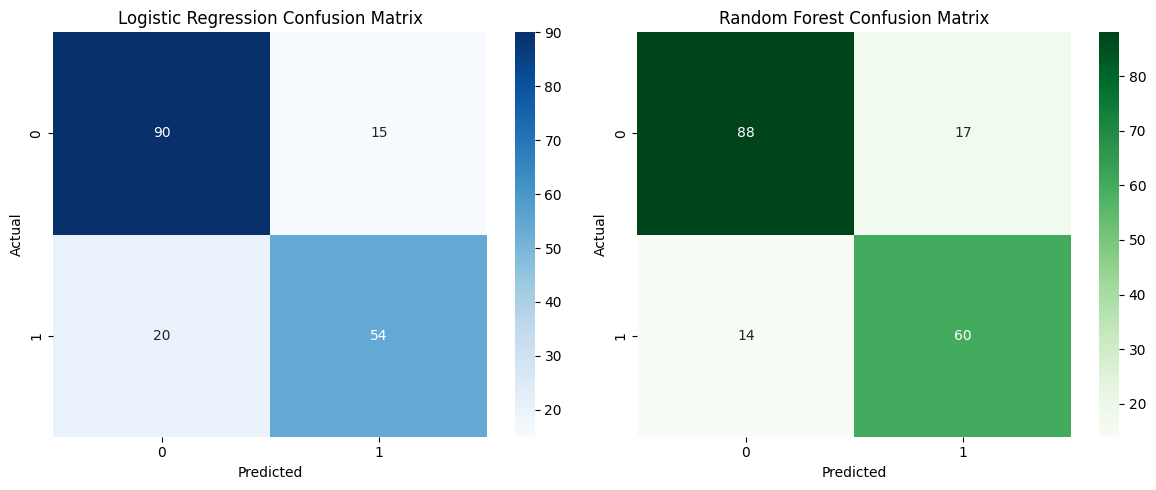

In [658]:
# Plotting confusion matrix

fig, axes = plt.subplots(1, 2, figsize=(12, 5))


# Logistic Regression

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Logistic Regression Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")


# Random Forest

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("Random Forest Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

Interpretation:
+ True Negatives (TN): Both models correctly predicted around 88–90 instances of Class 0.
+ True Positives (TP): Random Forest correctly identified 60 instances of Class 1, compared to 54 by Logistic Regression.
+ False Positives (FP): Logistic Regression had fewer false positives (15) than Random Forest (17).
+ False Negatives (FN): Random Forest had fewer false negatives (14) than Logistic Regression (20), meaning it missed fewer actual positives.

Key Takeaways:
+ Random Forest demonstrates better sensitivity (recall) for identifying positive cases (Class 1) by reducing false negatives.
+ Logistic Regression is slightly more conservative, with fewer false positives.
+ Overall, Random Forest provides a more balanced performance, making it a stronger candidate when recall of positive cases is important (e.g. survival detection in Titanic dataset).

#### ROC-AUC Score

In [659]:
# Logistic Regression: Predict Probabilities

y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
print("Logistic Regression - ROC AUC Score:", roc_auc_lr.round(4))


# Random Forest: Predict Probabilities

y_prob_rf = rf.predict_proba(X_test)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
print("Random Forest - ROC AUC Score:", roc_auc_rf.round(4))

Logistic Regression - ROC AUC Score: 0.8891
Random Forest - ROC AUC Score: 0.8837


Both models demonstrate strong discriminative ability, with ROC AUC scores close to 0.89, indicating they are effective at distinguishing between the positive and negative classes.

Although the difference is minimal, Logistic Regression slightly outperforms Random Forest in this metric, suggesting it has a marginally better ability to rank predictions correctly by class probability.

#### ROC Curve

In [660]:
# Get ROC metrics

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

auc_lr = auc(fpr_lr, tpr_lr)
auc_rf = auc(fpr_rf, tpr_rf)

While the AUC scores computed using both methods are the same, this format is used to extract the FPR and TPR values, which are necessary for plotting the ROC curve.

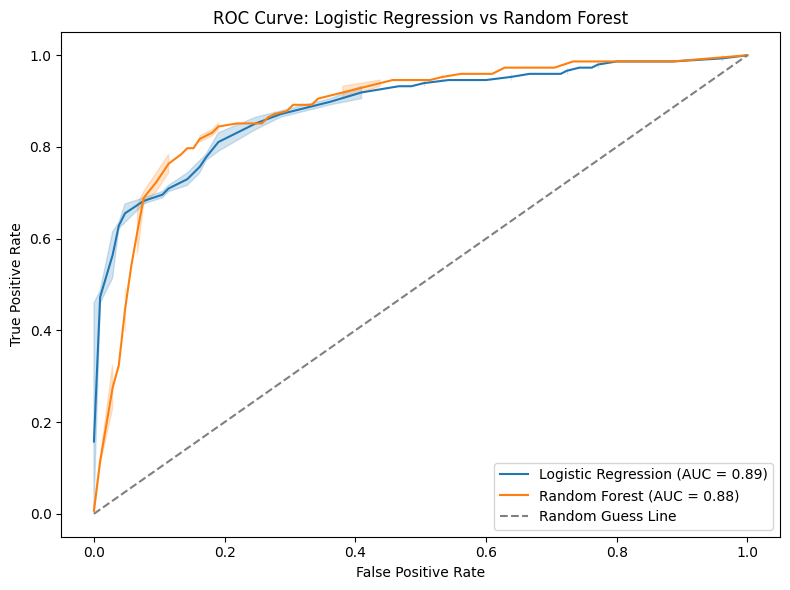

In [661]:
# Plot ROC Curve

plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr_lr, y=tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})")
sns.lineplot(x=fpr_rf, y=tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Random Guess Line", color="grey")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Logistic Regression vs Random Forest")
plt.tight_layout()
plt.show()

The ROC curve shows that both models perform well, with curves positioned well above the diagonal baseline. Logistic Regression has a slightly higher AUC score (0.89 vs 0.88), indicating it is marginally better at distinguishing between survivors and non-survivors. This is reflected in the ROC curve, where the Logistic Regression line lies slightly above the Random Forest curve across most threshold values.

This is reflected in the ROC curve, where the Logistic Regression line lies slightly above the Random Forest curve up to around a threshold of 0.7, indicating better performance in that range. Beyond 0.7, the Random Forest curve slightly surpasses Logistic Regression, suggesting that it performs marginally better at higher thresholds. Overall, Logistic Regression maintains a slightly higher AUC, indicating better overall discriminatory ability.

## Interpretation

To gain insight into how each feature impacts passenger survival, feature importance is analysed using both Logistic Regression coefficients and Random Forest importance scores.

#### Logistic Regression

In [662]:
# Check coefficients to understand feature impact

coefficients = pd.Series(lr.coef_[0], index=X.columns).sort_values(ascending=False)
print(coefficients.round(2))

Sex              1.28
Fare             0.13
Embarked_Q      -0.08
Embarked_S      -0.20
FamilyMembers   -0.39
Age             -0.40
Pclass          -0.78
dtype: float64


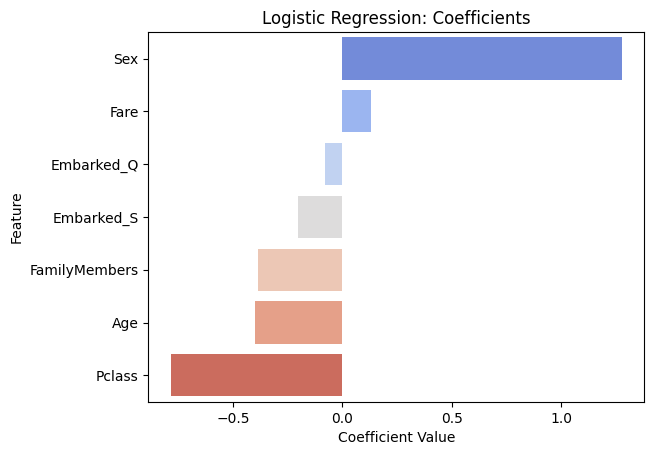

In [663]:
# Plotting coefficients

sns.barplot(x=coefficients.values, y=coefficients.index, palette='coolwarm', 
            hue=coefficients.index, legend=False)
plt.title("Logistic Regression: Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

#### Random Forest

In [664]:
# Check feature importance

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances)

Age              0.298877
Sex              0.278270
Fare             0.219805
Pclass           0.087351
FamilyMembers    0.080471
Embarked_S       0.025673
Embarked_Q       0.009554
dtype: float64


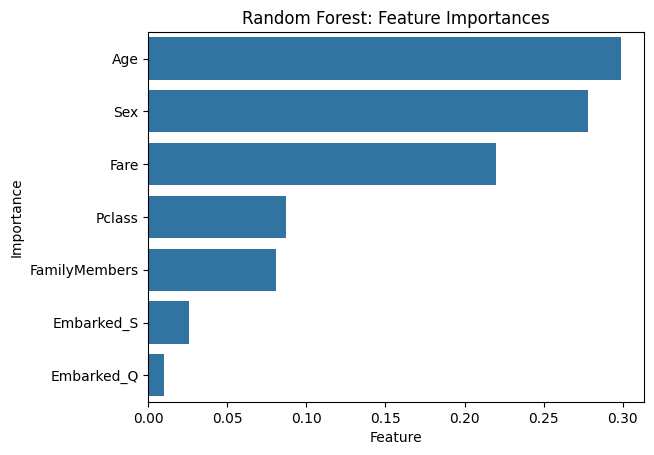

In [665]:
# Plotting feature importance

sns.barplot(x=importances.values, y=importances.index)
plt.title("Random Forest: Feature Importances")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()

#### Feature Comparison

Both the Logistic Regression and Random Forest models provide insight into which features most influence the prediction of passenger survival, but they do so in different ways. Logistic Regression provides coefficients that indicate the direction and strength of a feature's impact on the outcome, while Random Forest provides feature importance scores that reflect the relative contribution of each feature to the model’s predictive power.

Key Similarities:

Sex
+ Logistic Regression: Has the strongest positive coefficient (+1.28), indicating that being female significantly increases the chance of survival.
+ Random Forest: Also ranks Sex as one of the most important features, highlighting its critical role in survival prediction.

Fare
+ Logistic Regression: Positive coefficient (+0.13), showing that higher fare is associated with better survival odds.
+ Random Forest: Considered one of the top features, reinforcing its importance in predicting survival, likely due to its correlation with passenger class and socio-economic status.

Pclass
+ Logistic Regression: Strong negative coefficient (–0.78), indicating that lower-class passengers (higher Pclass values) had lower survival rates.
+ Random Forest: Assigned meaningful importance, confirming that passenger class has a significant effect on survival predictions.

Age
+ Logistic Regression: Negative coefficient (–0.40), suggesting older passengers were less likely to survive.
+ Random Forest: Ranked as the most influential feature, indicating that age contributes substantially to prediction accuracy.

FamilyMembers
+ Logistic Regression: Negative coefficient (–0.39), suggesting that passengers traveling in larger families had reduced survival chances.
+ Random Forest: Given moderate importance, supporting its relevance though possibly capturing more complex, non-linear effects.

Embarked_S and Embarked_Q
+ Logistic Regression: Both have small negative coefficients, indicating slightly reduced survival odds compared to the reference point (Embarked_C).
+ Random Forest: Considered less important, aligning with the idea that embarkation point is a minor factor relative to demographics and socio-economic indicators.

Overall, the coefficients and feature importance rankings are consistent with historical findings, highlighting demographics, gender, and socio-economic status as key determinants of survival.

Key Differences:

Interpretability
+ Logistic Regression provides interpretable coefficients that directly indicate the effect (positive or negative) of each feature on survival. In contrast, Random Forest offers importance rankings but not the direction of impact.

Feature Interactions
+ Random Forest can model non-linear relationships and interactions between variables (e.g. how Age and Pclass might interact), which Logistic Regression cannot capture unless explicitly engineered.

Age vs Sex Ranking
+ In Logistic Regression, Sex is the most influential feature, while in Random Forest, Age takes the top position. This may indicate that the Random Forest model is better at capturing more complex age-related survival patterns.

## Conclusion

Initially it was planned to run Logistic Regression and Random Forest with and without the Embarked features (Embarked_S, Embarked_Q) to assess their contribution and rule out multicollinearity.

Upon review:
+ In Logistic Regression, their coefficients (.coef_) were small, indicating little influence on the prediction.
+ In Random Forest, their feature importances were also low, meaning the model barely used them to make decisions.

Interpretation & Justification:
+ Low weight in both linear and non-linear models suggests these features contribute very little predictive power.
+ There's no strong evidence of multicollinearity (especially since Random Forest is not sensitive to it), and logistic regression didn't show instability.
+ Therefore, running additional models without Embarked features is unlikely to yield significant performance changes.
+ Removing them would add unnecessary complexity without meaningful insight.

Overall, Random Forest is the preferred modelling approach over Logistic Regression. It consistently delivered stronger performance across multiple evaluation metrics, including:
+ Higher accuracy score
+ Improved classification report metrics, including precision, recall, and F1-score
+ Better confusion matrix results, with fewer misclassifications
+ A comparable ROC-AUC score, indicating similarly strong ability to distinguish between classes

These results suggest that Random Forest provides a more robust and accurate predictive model for this classification task.

## Data Export Process

In [666]:
# Prediction on the full dataset

df['Prediction'] = rf.predict(X)


# Decode Embarked from one-hot encoded columns

def decode_embarked(row):
    if row['Embarked_Q'] == 1:
        return 'Q'
    elif row['Embarked_S'] == 1:
        return 'S'
    else:
        return 'C'

df['Embarked_decoded'] = df.apply(decode_embarked, axis=1)


# Export dataframe from the main dataframe

df_export = df[['Survived', 'Prediction', 'Pclass', 'Sex', 'Age', 'Fare', 'FamilyMembers', 'Embarked_decoded']].copy()


# Remapping Sex column back to string labels

df_export['Sex'] = df_export['Sex'].map({0: 'male', 1: 'female'})


# Export to CSV

df_export.to_csv('titanic_dataset_dashboard.csv', index=False)

To support dashboard development, a clean dataset was prepared by generating survival predictions using the trained model and selecting key features for analysis. The Embarked variable, originally one-hot encoded, was decoded into a single readable column (C, Q, S). The Sex column was mapped back to readable labels (male, female), and the dataset was exported to CSV without the index to ensure compatibility with visualisation tools like Power BI.

In [667]:
# Exporting Classification Report as Dictionary

report = classification_report(y_test, y_pred_rf, output_dict=True)


# Convert report to a DataFrame

df_report = pd.DataFrame(report).transpose()


# Save as CSV

df_report.to_csv('classification_report.csv', index=True)

A classification report was generated using classification_report() from scikit-learn, it was then converted into a pandas DataFrame, and exported to a CSV file. This was done to import and visualise key model performance metrics directly within my Power BI dashboard.

In [668]:
# Create DataFrame

roc_curve_data = pd.DataFrame({
    "False Positive Rate": fpr_rf,
    "True Positive Rate": tpr_rf
})


# Export ROC Curve to CSV

roc_curve_data.to_csv('roc_curve_data.csv', index=False)

The False Positive Rate (FPR) and True Positive Rate (TPR) have been exported to a CSV file for use in the Power BI dashboard.

In [669]:
# Export Feature Importance to CSV

importances.to_csv('feature_importances.csv', header=['Importance'])

The Random Forest feature importances, already stored as a Pandas Series, were exported to a CSV file.